In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torchvision
import gc
import time
from torchvision import transforms,models,datasets
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
from PIL import Image
import seaborn as sns
import helper
import numpy as np
import pandas as pd
import json
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
print(os.listdir('/content/drive/My Drive/Coriander_vs_Parsley'))

['README.md', 'train', 'test']


In [5]:
train_transforms=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
test_transforms=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
train_datasets = datasets.ImageFolder('/content/drive/My Drive/Coriander_vs_Parsley/train',transform=train_transforms)
test_datasets = datasets.ImageFolder('/content/drive/My Drive/Coriander_vs_Parsley/test',transform=test_transforms)

trainloader=torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True)
testloader=torch.utils.data.DataLoader(test_datasets, batch_size=64, shuffle=True)
print("train size: " , len(trainloader.dataset))
print("test size: " , len(testloader.dataset))

train size:  193
test size:  51


tensor(0)


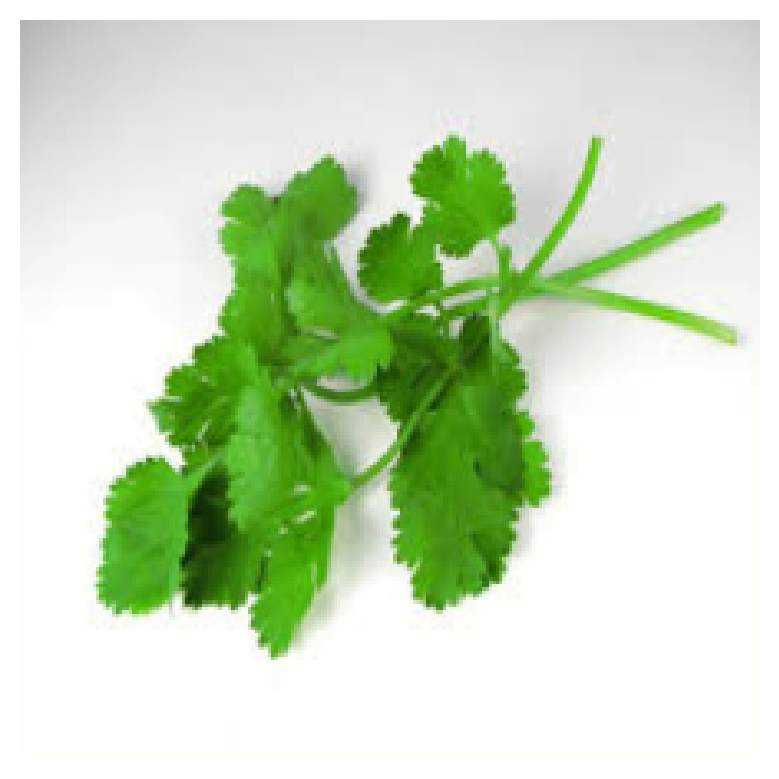

In [6]:
def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax
data_iter = iter(trainloader)
images, labels = next(data_iter)
imshow(images[0])
print(labels[0])

In [7]:
# we will use a pretrained model and we are going to change only the last layer
model = models.densenet201(pretrained=True)
for param in model.parameters():
  param.requires_grad= True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 218MB/s]


In [8]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
classifier  = nn.Sequential(nn.Linear(1920, 256),
                          nn.ReLU(),
                          nn.Linear(256, 2),
                          nn.LogSoftmax(dim = 1))
model.classifier=classifier

In [10]:
if torch.cuda.is_available():
  model.to('cuda')
  device='cuda'
else:
    model.to('cpu')
    device='cpu'
print(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.00001,weight_decay=0)
test_loss_min = 99 #just a big number I could do np.Inf
save_file='mymodel.pth'

cuda


In [11]:
epochs = 200
train_losses = []
test_losses = []
print_every = 10
running_loss = 0
for epoch in range(epochs):
    time0=time.time()
    model.train()
    for inputs, labels in trainloader:
        # Move inp  ut and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        prediction = model.forward(inputs)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    else:
        train_losses.append(running_loss/(len(trainloader)))
        running_loss = 0
        if ((epoch % print_every) == 0):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()

                        # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                total_loss=test_loss/len(testloader)
                print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {running_loss/(len(trainloader) * print_every):.3f}.. "
                f"test loss: {test_loss/len(testloader):.3f}.. "
                f"test accuracy: {accuracy/len(testloader):.3f}")
                time_total=time.time() - time0
                print("time for this epoch: ",end="")
                print(time_total)
#                 train_losses.append(running_loss/(len(trainloader) * print_every))
                test_losses.append(total_loss)
                if (total_loss) <= test_loss_min:
                    print('test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min,total_loss))
                    torch.save(model.state_dict(), save_file)
                    test_loss_min = total_loss
                running_loss = 0

Epoch 1/200.. Train loss: 0.000.. test loss: 0.699.. test accuracy: 0.431
time for this epoch: 82.6384539604187
test loss decreased (99.000000 --> 0.699303).  Saving model ...
Epoch 11/200.. Train loss: 0.000.. test loss: 0.675.. test accuracy: 0.569
time for this epoch: 4.93536376953125
test loss decreased (0.699303 --> 0.675338).  Saving model ...
Epoch 21/200.. Train loss: 0.000.. test loss: 0.674.. test accuracy: 0.569
time for this epoch: 5.192459583282471
test loss decreased (0.675338 --> 0.674152).  Saving model ...
Epoch 31/200.. Train loss: 0.000.. test loss: 0.679.. test accuracy: 0.569
time for this epoch: 4.868926048278809
Epoch 41/200.. Train loss: 0.000.. test loss: 0.675.. test accuracy: 0.569
time for this epoch: 5.283760070800781
Epoch 51/200.. Train loss: 0.000.. test loss: 0.661.. test accuracy: 0.569
time for this epoch: 4.880338907241821
test loss decreased (0.674152 --> 0.660619).  Saving model ...
Epoch 61/200.. Train loss: 0.000.. test loss: 0.656.. test accurac

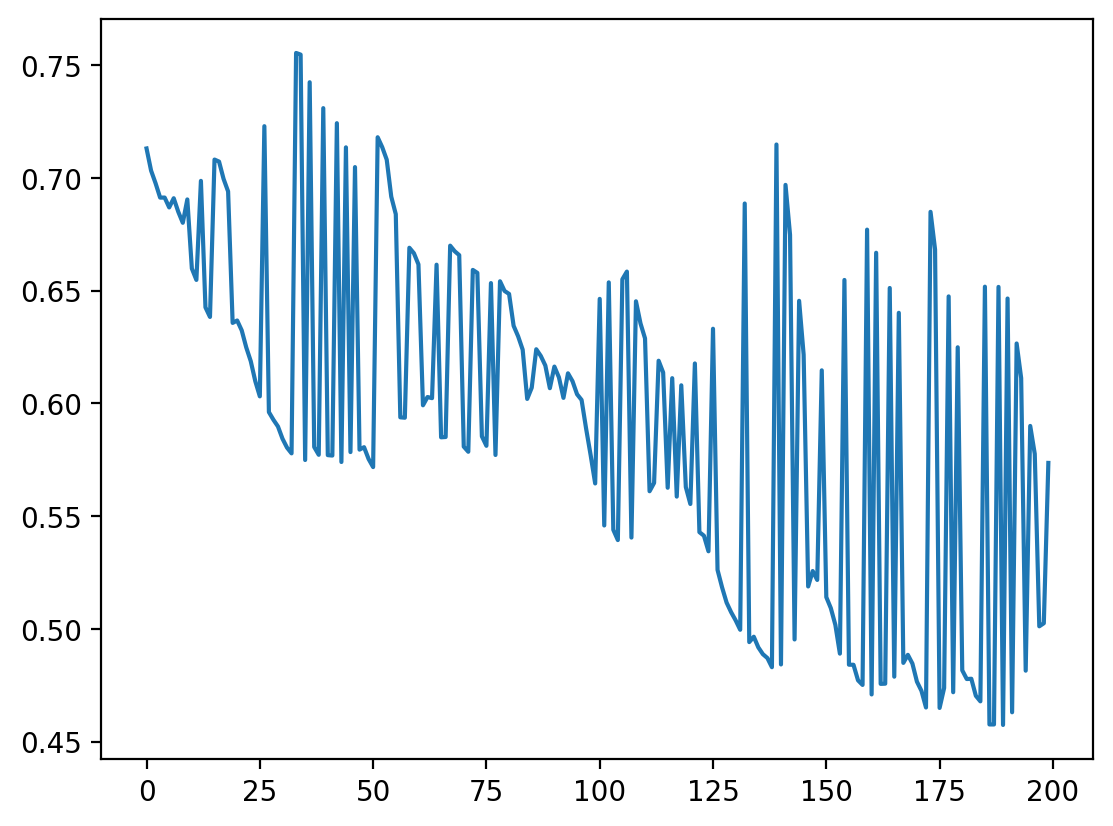

In [12]:
plt.plot(train_losses)
# plt.plot([k for k in range(0,epochs,print_every)],test_losses)
plt.show()

In [13]:
torch.save(model.state_dict(), '/content/drive/My Drive/Coriander_vs_Parsley/coriander_vs_parsley_model_weights.pth')
